# 1. Sentiment analysis

Using the [Large Movie Review Dataset](http://ai.stanford.edu/~amaas/data/sentiment/), we want to do a regression model that predict the ratings are on a 1-10 scale. You have an example train and test set in the `dataset` folder.

### 1.1 Regression Model

Use a feedforward neural network and NLP techniques we've seen up to now to train the best model you can on this dataset

### 1.2 RNN model

Train a RNN to do the sentiment analysis regression. The RNN should consist simply of an embedding layer (to make word IDs into word vectors) a recurrent blocks (GRU or LSTM) feeding into an output layer.

In [2]:
#! pip3 install torch torchvision torchaudio

In [7]:
#! pip install -U d2l

In [8]:
import os
import torch
from torch import nn
from d2l import torch as d2l

In [9]:
d2l.DATA_HUB['aclImdb'] = (
    'http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz',
    '01ada507287d82875905620988597833ad4e0903')

data_dir = d2l.download_extract('aclImdb', 'aclImdb')

In [10]:
def read_imdb(data_dir, is_train):
    data, labels = [], []
    for label in ('pos', 'neg'):
        folder_name = os.path.join(data_dir, 'train' if is_train else 'test',
                                   label)
        for file in os.listdir(folder_name):
            with open(os.path.join(folder_name, file), 'rb') as f:
                review = f.read().decode('utf-8').replace('\n', '')
                data.append(review)
                labels.append(1 if label == 'pos' else 0)
    return data, labels

train_data = read_imdb(data_dir, is_train=True)
print('# trainings:', len(train_data[0]))
for x, y in zip(train_data[0][:3], train_data[1][:3]):
    print('label:', y, 'review:', x[0:60])

# trainings: 25000
label: 1 review: For a movie that gets no respect there sure are a lot of mem
label: 1 review: Bizarre horror movie filled with famous faces but stolen by 
label: 1 review: A solid, if unremarkable film. Matthau, as Einstein, was won


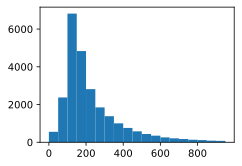

In [13]:
train_tokens = d2l.tokenize(train_data[0], token='word')
vocab = d2l.Vocab(train_tokens, min_freq=5, reserved_tokens=['<pad>'])

d2l.set_figsize()
d2l.plt.hist([len(line) for line in train_tokens], bins=range(0, 1000, 50))

In [14]:
num_steps = 500  # sequence length
train_features = torch.tensor([
    d2l.truncate_pad(vocab[line], num_steps, vocab['<pad>'])
    for line in train_tokens])
print(train_features.shape)

torch.Size([25000, 500])


In [16]:
train_iter = d2l.load_array((train_features, torch.tensor(train_data[1])), 64)

for X, y in train_iter:
    print('X:', X.shape, ', y:', y.shape)
    break
print('# batches:', len(train_iter))

X: torch.Size([64, 500]) , y: torch.Size([64])
# batches: 391


In [22]:
def load_data_imdb(batch_size, num_steps=500):
    data_dir = d2l.download_extract('aclImdb', 'aclImdb')
    train_data = read_imdb(data_dir, True)
    test_data = read_imdb(data_dir, False)
    train_tokens = d2l.tokenize(train_data[0], token='word')
    test_tokens = d2l.tokenize(test_data[0], token='word')
    vocab = d2l.Vocab(train_tokens, min_freq=5)
    train_features = torch.tensor([
        d2l.truncate_pad(vocab[line], num_steps, vocab['<pad>'])
        for line in train_tokens])
    test_features = torch.tensor([
        d2l.truncate_pad(vocab[line], num_steps, vocab['<pad>'])
        for line in test_tokens])
    train_iter = d2l.load_array((train_features, torch.tensor(train_data[1])),
                                batch_size)
    test_iter = d2l.load_array((test_features, torch.tensor(test_data[1])),
                               batch_size, is_train=False)
    return train_iter, test_iter, vocab

In [29]:
batch_size = 64
train_iter, test_iter, vocab = d2l.load_data_imdb(batch_size)

In [30]:
class BiRNN(nn.Module):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 **kwargs):
        super(BiRNN, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        # Set `bidirectional` to True to get a bidirectional recurrent neural
        # network
        self.encoder = nn.LSTM(embed_size, num_hiddens, num_layers=num_layers,
                               bidirectional=True)
        self.decoder = nn.Linear(4 * num_hiddens, 2)

    def forward(self, inputs):
        # The shape of `inputs` is (batch size, no. of words). Because LSTM
        # needs to use sequence as the first dimension, the input is
        # transformed and the word feature is then extracted. The output shape
        # is (no. of words, batch size, word vector dimension).
        embeddings = self.embedding(inputs.T)
        # Since the input (embeddings) is the only argument passed into
        # nn.LSTM, both h_0 and c_0 default to zero.
        # we only use the hidden states of the last hidden layer
        # at different time step (outputs). The shape of `outputs` is
        # (no. of words, batch size, 2 * no. of hidden units).
        self.encoder.flatten_parameters()
        outputs, _ = self.encoder(embeddings)
        # Concatenate the hidden states of the initial time step and final
        # time step to use as the input of the fully connected layer. Its
        # shape is (batch size, 4 * no. of hidden units)
        encoding = torch.cat((outputs[0], outputs[-1]), dim=1)
        outs = self.decoder(encoding)
        return outs

In [31]:
embed_size, num_hiddens, num_layers, devices = 100, 100, 2, d2l.try_all_gpus()
net = BiRNN(len(vocab), embed_size, num_hiddens, num_layers)

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)
    if type(m) == nn.LSTM:
        for param in m._flat_weights_names:
            if "weight" in param:
                nn.init.xavier_uniform_(m._parameters[param])

net.apply(init_weights)

BiRNN(
  (embedding): Embedding(49346, 100)
  (encoder): LSTM(100, 100, num_layers=2, bidirectional=True)
  (decoder): Linear(in_features=400, out_features=2, bias=True)
)

In [32]:
glove_embedding = d2l.TokenEmbedding('glove.6b.100d')

In [33]:
embeds = glove_embedding[vocab.idx_to_token]
embeds.shape

torch.Size([49346, 100])

In [34]:
net.embedding.weight.data.copy_(embeds)
net.embedding.weight.requires_grad = False

loss 0.283, train acc 0.879, test acc 0.861
2.1 examples/sec on [device(type='cpu')]


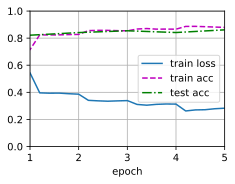

In [35]:
lr, num_epochs = 0.01, 5
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction="none")
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

In [36]:
def predict_sentiment(net, vocab, sentence):
    sentence = torch.tensor(vocab[sentence.split()], device=d2l.try_gpu())
    label = torch.argmax(net(sentence.reshape(1, -1)), dim=1)
    return 'positive' if label == 1 else 'negative'

In [48]:
predict_sentiment(net, vocab, 'this movie is so good')

'positive'

In [38]:
predict_sentiment(net, vocab, 'this movie is so bad')

'negative'

# 2. (evil) XOR Problem

Train an LSTM to solve the XOR problem: that is, given a sequence of bits, determine its parity. The LSTM should consume the sequence, one bit at a time, and then output the correct answer at the sequence’s end. Test the two approaches below:

### 2.1 

Generate a dataset of random <=100,000 binary strings of equal length <= 50. Train the LSTM; what is the maximum length you can train up to with precisison?
    

### 2.2

Generate a dataset of random <=200,000 binary strings, where the length of each string is independently and randomly chosen between 1 and 50. Train the LSTM. Does it succeed? What explains the difference?


In [56]:
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dense, Input, LSTM, Activation
from tensorflow.keras.models import Sequential
import numpy as np
import random

In [57]:
SEQ_LEN = 50
COUNT = 100000

bin_pair = lambda x: [x, not(x)]
training = np.array([[bin_pair(random.choice([0, 1])) for _ in range(SEQ_LEN)] for _ in range(COUNT)])
target = np.array([[bin_pair(x) for x in np.cumsum(example[:,0]) % 2] for example in training])

print('shape check:', training.shape, '=', target.shape)

model = Sequential()
model.add(Input(shape=(SEQ_LEN, 2), dtype='float32'))
model.add(LSTM(1, return_sequences=True))
model.add(Dense(2, activation='softmax'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(training, target, epochs=10, batch_size=128)
model.summary()

predictions = model.predict(training)
i = random.randint(0, COUNT)
chance = predictions[i,-1,0]
print('randomly selected sequence:', training[i,:,0])
print('prediction:', int(chance > 0.5))
print('confidence: {:0.2f}%'.format((chance if chance > 0.5 else 1 - chance) * 100))
print('actual:', np.sum(training[i,:,0]) % 2)

shape check: (100000, 50, 2) = (100000, 50, 2)
Epoch 1/10
782/782 [==============================] - 13s 15ms/step - loss: 0.6971 - accuracy: 0.5002
Epoch 2/10
782/782 [==============================] - 11s 14ms/step - loss: 0.6932 - accuracy: 0.5009
Epoch 3/10
782/782 [==============================] - 11s 14ms/step - loss: 0.6931 - accuracy: 0.4974
Epoch 4/10
782/782 [==============================] - 11s 14ms/step - loss: 0.6931 - accuracy: 0.5050
Epoch 5/10
782/782 [==============================] - 11s 14ms/step - loss: 0.6931 - accuracy: 0.5056
Epoch 6/10
782/782 [==============================] - 11s 14ms/step - loss: 0.6931 - accuracy: 0.5063
Epoch 7/10
782/782 [==============================] - 11s 14ms/step - loss: 0.6931 - accuracy: 0.5076
Epoch 8/10
782/782 [==============================] - 11s 14ms/step - loss: 0.6930 - accuracy: 0.5090
Epoch 9/10
782/782 [==============================] - 11s 14ms/step - loss: 0.6930 - accuracy: 0.5098
Epoch 10/10
782/782 [==============

In [ ]:
SEQ_LEN = 50
COUNT = 200000

bin_pair = lambda x: [x, not(x)]
training = np.array([[bin_pair(random.choice([0, 1])) for _ in range(SEQ_LEN)] for _ in range(COUNT)])
target = np.array([[bin_pair(x) for x in np.cumsum(example[:,0]) % 2] for example in training])

print('shape check:', training.shape, '=', target.shape)

model = Sequential()
model.add(Input(shape=(SEQ_LEN, 2), dtype='float32'))
model.add(LSTM(1, return_sequences=True))
model.add(Dense(2, activation='softmax'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(training, target, epochs=10, batch_size=128)
model.summary()

predictions = model.predict(training)
i = random.randint(0, COUNT)
chance = predictions[i,-1,0]
print('randomly selected sequence:', training[i,:,0])
print('prediction:', int(chance > 0.5))
print('confidence: {:0.2f}%'.format((chance if chance > 0.5 else 1 - chance) * 100))
print('actual:', np.sum(training[i,:,0]) % 2)